In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from keras.layers import (
    Input, Concatenate, Dense, Activation, TextVectorization,
    Embedding, GlobalAveragePooling1D, Conv1D, AveragePooling1D, 
    Reshape, LSTM
)
from keras.models import Model
import tensorflow as tf

In [2]:
df = pd.read_csv("data/toxic_train.csv")

In [3]:
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [7]:
df["is_negative"] = (df.toxic | df.severe_toxic | df.obscene | df.threat | df.insult | df.identity_hate).astype(int)
df["is_negative"].value_counts()

is_negative
0    143346
1     16225
Name: count, dtype: int64

In [ ]:
df_2 = pd.read_csv("data/bad-words.csv")

In [8]:
# Resample the dataset to have a balanced number of positive and negative examples
df_negative = df[df["is_negative"] == 1]
df_positive = df[df["is_negative"] == 0].sample(n=len(df_negative), random_state=42)

df = pd.concat([df_negative, df_positive])
df["is_negative"].value_counts()

is_negative
1    16225
0    16225
Name: count, dtype: int64

In [9]:
y = df["is_negative"].to_numpy()
X = df["comment_text"].to_numpy()

ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y.reshape(-1, 1)).todense()
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe)

In [12]:
def convolve_and_downsample(input_n_samples, input_embedding_size, n_filters, kernel_size=3, **kwargs):
    input_layer = Input(shape=(input_n_samples,input_embedding_size))
    x = input_layer
    x = Conv1D( filters=n_filters,
                kernel_size=kernel_size,
                padding='same',
                use_bias=False,
                )(x)
    x = AveragePooling1D(pool_size=2)(x)
    x = Activation('elu')(x)
    return Model(input_layer, x, **kwargs)

vocab_size = 1000
def deep_cnn_embedding_softmax_model(vectorize_layer, vocab_size=vocab_size, number_of_ngrams=32, n_gram_size=3):
    input_layer = Input(shape=(1,), dtype=tf.string)
    x = input_layer
    x = vectorize_layer(x)
    x = Embedding(vocab_size, 2, name='projecao')(x)
    x = convolve_and_downsample(256, 2, number_of_ngrams, n_gram_size, name='ngramas')(x)
    x = convolve_and_downsample(128, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(64, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(32, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(16, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(8, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(4, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = convolve_and_downsample(2, number_of_ngrams, number_of_ngrams, n_gram_size)(x)
    x = Reshape((-1,))(x)
    x = Dense(2, name='classificador')(x)
    x = Activation('softmax')(x)
    return Model(input_layer, x)

def blstm_softmax_model(vectorize_layer, vocab_size=vocab_size):
    input_layer = Input(shape=(1,), dtype=tf.string)
    x = input_layer
    x = vectorize_layer(x)
    x = Embedding(vocab_size, 2, name='projecao')(x)
    x1 = LSTM(1)(x)
    x2 = LSTM(1, go_backwards=True)(x)
    x = Concatenate()([x1, x2])
    x = Dense(2, name='classificador')(x)
    x = Activation('softmax')(x)
    return Model(input_layer, x)


In [13]:
vectorize_layer = TextVectorization(output_mode='int', max_tokens=vocab_size, pad_to_max_tokens=True, output_sequence_length=256)
vectorize_layer.adapt(X_train)
# clf2 = deep_cnn_embedding_softmax_model(vectorize_layer)
clf2 = blstm_softmax_model(vectorize_layer)
print(clf2.summary())
clf2.compile(loss='categorical_crossentropy', metrics=['accuracy'])
history = clf2.fit(X_train, y_train, epochs=25, verbose=1, validation_split=0.1)
clf2.evaluate(X_test, y_test)

2023-04-21 22:34:41.571382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-21 22:34:41.595785: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 256)         0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 projecao (Embedding)           (None, 256, 2)       2000        ['text_vectorization[0][0]']     
                                                                                                  
 lstm (LSTM)                    (None, 1)            16          ['projecao[0][0]']           

2023-04-21 22:34:45.001923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 22:34:45.003107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 22:34:45.003995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

None
Epoch 1/25


2023-04-21 22:34:45.438782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 22:34:45.440043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 22:34:45.440962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

685/685 [==============================] - ETA: 0s - loss: 0.6097 - accuracy: 0.7132

2023-04-21 22:35:32.791392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-21 22:35:32.792490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-21 22:35:32.793380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

685/685 [==============================] - 49s 66ms/step - loss: 0.6097 - accuracy: 0.7132 - val_loss: 0.5359 - val_accuracy: 0.7691
Epoch 2/25
685/685 [==============================] - 49s 72ms/step - loss: 0.4537 - accuracy: 0.8317 - val_loss: 0.3984 - val_accuracy: 0.8468
Epoch 3/25
685/685 [==============================] - 49s 71ms/step - loss: 0.3563 - accuracy: 0.8641 - val_loss: 0.3517 - val_accuracy: 0.8632
Epoch 4/25
245/685 [=========>....................] - ETA: 31s - loss: 0.3212 - accuracy: 0.8759

KeyboardInterrupt: 

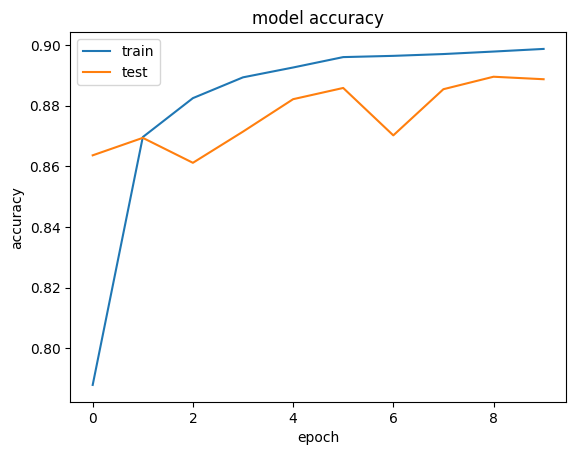

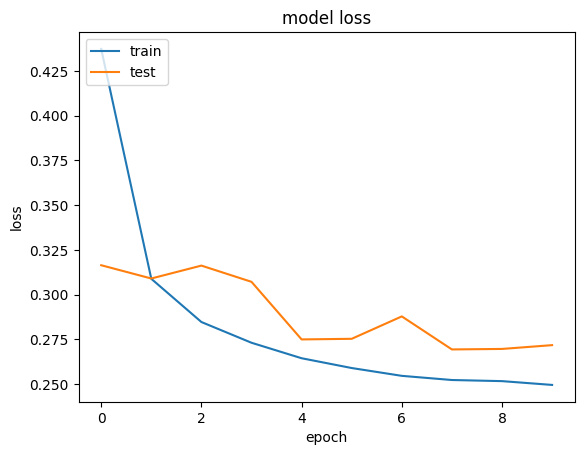

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
